In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

100% 810M/812M [00:05<00:00, 174MB/s]
100% 812M/812M [00:05<00:00, 154MB/s]


In [4]:
import os, shutil, pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory

In [5]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [6]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [7]:
conv_base  = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
conv_base.trainable = False

conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

58889256/58889256 [==============================] - 0s 0us/step
This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [9]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.tf",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 26s 221ms/step - loss: 19.7022 - accuracy: 0.8855 - val_loss: 2.8402 - val_accuracy: 0.9710
Epoch 2/50
63/63 [==============================] - 9s 136ms/step - loss: 6.1572 - accuracy: 0.9420 - val_loss: 3.6406 - val_accuracy: 0.9710
Epoch 3/50
63/63 [==============================] - 11s 169ms/step - loss: 5.4060 - accuracy: 0.9635 - val_loss: 4.0798 - val_accuracy: 0.9700
Epoch 4/50
63/63 [==============================] - 9s 133ms/step - loss: 4.4000 - accuracy: 0.9650 - val_loss: 4.6249 - val_accuracy: 0.9720
Epoch 5/50
63/63 [==============================] - 9s 135ms/step - loss: 4.4859 - accuracy: 0.9610 - val_loss: 3.5173 - val_accuracy: 0.9780
Epoch 6/50
63/63 [==============================] - 9s 137ms/step - loss: 3.6544 - accuracy: 0.9695 - val_loss: 3.6915 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 9s 135ms/step - loss: 2.8221 - accuracy: 0.9725 - val_loss: 3.5865 - val_accuracy: 0.9780
Epo

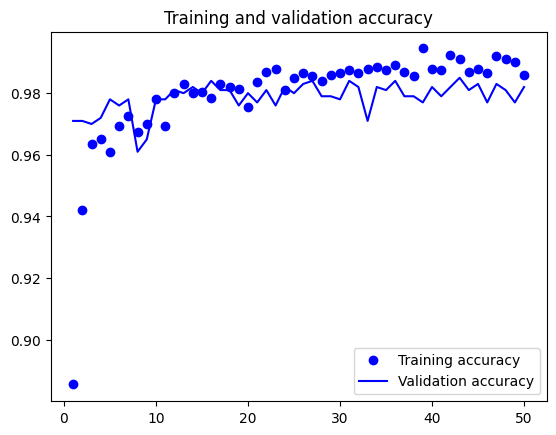

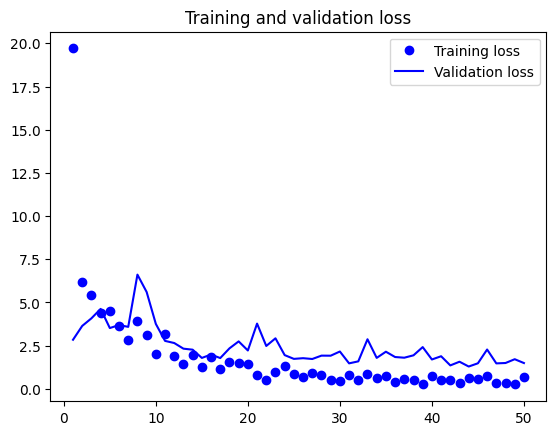

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [12]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.tf")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 89ms/step - loss: 2.7870 - accuracy: 0.9705
Test accuracy: 0.970
